<a href="https://colab.research.google.com/github/tawfiqmislam/C-Programming/blob/main/pytorch_facial_emotion_recognition_with_affectnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

import zipfile

Facial_Expression_Dataset = "Facial_Expression_Dataset.zip"
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Data/"+Facial_Expression_Dataset, 'r')
zip_ref.extractall("/content/data")

zip_ref.close()



In [ ]:
def get_device(torch):
  return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [ ]:
import torch
print(get_device(torch))

cuda:0


In [ ]:
import os, os.path

src = "data/Facial_Expression_Dataset"
classes = os.listdir(src)
for emo_index, aClass in enumerate(classes):
  sub_dirs = os.listdir(src+"/"+aClass)
  for aSub_dir in sub_dirs:
      print(src+"/"+aClass+"/"+aSub_dir)

data/Facial_Expression_Dataset/negative/FER2013_disgust
data/Facial_Expression_Dataset/negative/SFEW_val_sad
data/Facial_Expression_Dataset/negative/SFEW_sad
data/Facial_Expression_Dataset/negative/SFEW_val_angry
data/Facial_Expression_Dataset/negative/FER2013_test_sad
data/Facial_Expression_Dataset/negative/FER2013_test_angry
data/Facial_Expression_Dataset/negative/RAFDB_test_sad
data/Facial_Expression_Dataset/negative/RAFDB_test_disgust
data/Facial_Expression_Dataset/negative/SFEW_val_disgust
data/Facial_Expression_Dataset/negative/SFEW_disgust
data/Facial_Expression_Dataset/negative/SFEW_angry
data/Facial_Expression_Dataset/negative/FER2013_angry
data/Facial_Expression_Dataset/negative/FER2013_sad
data/Facial_Expression_Dataset/negative/FER2013_test_disgust
data/Facial_Expression_Dataset/negative/RAFDB_test_angry
data/Facial_Expression_Dataset/negative/RAFDB_angry
data/Facial_Expression_Dataset/negative/RAFDB_sad
data/Facial_Expression_Dataset/negative/RAFDB_disgust
data/Facial_Expr

In [ ]:
# data loaders
# !pip install python-resize-image

import os, os.path
import pandas as pd
import numpy as np
from PIL import Image
# from resizeimage import resizeimage
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Plain_Dataset(Dataset):
    def __init__(self,src,labels,transform):
        emotion = []
        img_list = []

        if src:
          for idx, path in enumerate(src):
            emo_index = -1
            for emo, aLabel in enumerate(labels):
              if len(path.lower().split("/"+aLabel.lower()+"/"))==2:
                emo_index = emo
            
            if emo_index<0:
               print("Unable to identify Label of Source {aLabel}")

            img_list_sub, emotion_sub = find_images(path, emo_index);
            img_list.extend(img_list_sub)
            emotion.extend(emotion_sub)
            # for f in os.listdir(path):
            #     ext = os.path.splitext(f)[1]
            #     if ext.lower() not in valid_images:
            #         continue
            #     image_path = os.path.join(path,f)
            #     resize_to_desired_image(self, image_path, width=48, height=48)
            #     emotion.append(emo_index)
            #     img_list.append(image_path)

        self.labels = emotion
        self.img_list = img_list
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
       
        img = Image.open(self.img_list[idx]) # new
        lables = np.array(self.labels[idx])
        lables = torch.from_numpy(lables).long()

        if self.transform :
            img = self.transform(img)
        
        return img,lables
    
#Helper function
def eval_data_dataloader(csv_file,img_dir,datatype,sample_number,transform= None):
    '''
    Helper function used to evaluate the Dataset class
    params:-
            csv_file : the path of the csv file    (train, validation, test)
            img_dir  : the directory of the images (train, validation, test)
            datatype : string for searching along the image_dir (train, val, test)
            sample_number : any number from the data to be shown
    '''
    if transform is None :
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
    dataset = Plain_Dataset(csv_file=csv_file,img_dir = img_dir,datatype = datatype,transform = transform)

    label = dataset.__getitem__(sample_number)[1]
    print(label)
    imgg = dataset.__getitem__(sample_number)[0]
    imgnumpy = imgg.numpy()
    imgt = imgnumpy.squeeze()
    plt.imshow(imgt)
    plt.show()

def resize_to_desired_image(image_path, width=48, height=48):
  with open(image_path, 'r+b') as f:
      with Image.open(f) as image:
          image = image.convert('L')
          # cover = resizeimage.resize_thumbnail(image, [width, height])
          image = image.resize((width, height), Image.ANTIALIAS)
          image.save(image_path, image.format)

def find_images(path,emo_index):
  valid_images = [".jpg",".gif",".png",".tga"]

  emotion = []
  img_list = []
  for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() in valid_images: 
      image_path = os.path.join(path,f)
      resize_to_desired_image(image_path, width=48, height=48)
      emotion.append(emo_index)
      img_list.append(image_path)
    else:
      img_list_sub, emotion_sub = find_images(os.path.join(path,f),emo_index)
      emotion.extend(emotion_sub)
      img_list.extend(img_list_sub)
  return img_list, emotion

In [ ]:

'''ResNet in PyTorch.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''

# 10 crop for data enhancement
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
# import transforms as transforms
from torchvision import transforms
import numpy as np
import os
import argparse
import torch.utils
# from fer import FER2013
from torch.autograd import Variable
import json
import torchvision.models as models

try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
# main

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

device = get_device(torch)

# Training
def TrainResnet18(epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    top_train_accuracy_yet = 0

    top_train_labels = []
    top_train_pred_labels = []
    top_val_labels = []
    top_val_pred_labels = []

    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        current_train_pred_labels=[]
        current_train_labels=[]
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)
            current_train_pred_labels.append(preds)
            current_train_labels.append(labels)

        #validate the model#
        current_val_pred_labels = []
        current_val_labels = []
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)
            current_val_pred_labels.append(val_preds)
            current_val_labels.append(labels)

        train_loss = train_loss/len(train_dataset)
        train_acc = train_correct.double() / len(train_dataset)
        validation_loss =  validation_loss / len(val_dataset)
        val_acc = val_correct.double() / len(val_dataset)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))
        if train_acc >= top_train_accuracy_yet:
          top_train_pred_labels = current_train_pred_labels
          top_train_labels = current_train_labels
          top_val_pred_labels = current_val_pred_labels
          top_val_labels = current_val_labels

    torch.save(net.state_dict(),'resnet18-{}-{}-{}.pt'.format(epochs,batchsize,lr))


    torch.save(top_train_labels, 'top_train_labels.labels')
    torch.save(top_train_pred_labels, 'top_train_pred_labels.labels')
    torch.save(top_val_labels, 'top_val_labels.labels')
    torch.save(top_val_pred_labels, 'top_val_pred_labels.labels')
    
    print("===================================Training Finished===================================")
    return top_train_labels,top_train_pred_labels,top_val_labels,top_val_pred_labels


if __name__ == '__main__':

    setup = True # one time
    datasrc = "data/Facial_Expression_Dataset/"
    
    # hyperparams = False
    train = True #False
    model_name = 'resnet18_model_facial_expression_datast.pt'
    load_saved_model = True


    epochs = 50
    lr = 0.005
    batchsize = 128


    labels = os.listdir(datasrc) # 'positive', 'negative'
    labels.sort(reverse=True) # 'negative', 'positive' # not needed in future


    if train:

        net = models.resnet18(pretrained=True, progress=True)
        #net.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) #default input layer
        net.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=0, bias=False) #override input layer
        # net.fc = nn.Linear(net.fc.in_features, 1000) #default output layer
        net.fc = nn.Linear(net.fc.in_features, len(labels)) #override output layer

        net.to(device)
        print("Model archticture: ", net)

        transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

        full_data_src = ['data/Facial_Expression_Dataset/positive/RAFDB_happy',
        'data/Facial_Expression_Dataset/positive/FER2013_happy',
        'data/Facial_Expression_Dataset/positive/RAFDB_test_happy',
        'data/Facial_Expression_Dataset/positive/SFEW_val_happy',
        'data/Facial_Expression_Dataset/positive/FER2013_test_happy',
        'data/Facial_Expression_Dataset/positive/SFEW_happy',
        'data/Facial_Expression_Dataset/negative/SFEW_val_sad',
        'data/Facial_Expression_Dataset/negative/FER2013_sad',
        'data/Facial_Expression_Dataset/negative/SFEW_val_angry',
        'data/Facial_Expression_Dataset/negative/SFEW_val_disgust',
        'data/Facial_Expression_Dataset/negative/RAFDB_disgust',
        'data/Facial_Expression_Dataset/negative/FER2013_test_angry',
        'data/Facial_Expression_Dataset/negative/FER2013_angry',
        'data/Facial_Expression_Dataset/negative/FER2013_test_sad',
        'data/Facial_Expression_Dataset/negative/RAFDB_sad',
        'data/Facial_Expression_Dataset/negative/RAFDB_test_sad',
        'data/Facial_Expression_Dataset/negative/RAFDB_test_angry',
        'data/Facial_Expression_Dataset/negative/FER2013_disgust',
        'data/Facial_Expression_Dataset/negative/SFEW_angry',
        'data/Facial_Expression_Dataset/negative/RAFDB_test_disgust',
        'data/Facial_Expression_Dataset/negative/FER2013_test_disgust',
        'data/Facial_Expression_Dataset/negative/SFEW_disgust',
        'data/Facial_Expression_Dataset/negative/SFEW_sad',
        'data/Facial_Expression_Dataset/negative/RAFDB_angry']

        train_src = ['data/Facial_Expression_Dataset/positive/RAFDB_happy',
        'data/Facial_Expression_Dataset/positive/FER2013_happy',
        'data/Facial_Expression_Dataset/positive/SFEW_happy',
        'data/Facial_Expression_Dataset/negative/FER2013_sad',
        'data/Facial_Expression_Dataset/negative/RAFDB_disgust',
        'data/Facial_Expression_Dataset/negative/FER2013_angry',
        'data/Facial_Expression_Dataset/negative/RAFDB_sad',
        'data/Facial_Expression_Dataset/negative/FER2013_disgust',
        'data/Facial_Expression_Dataset/negative/SFEW_angry',
        'data/Facial_Expression_Dataset/negative/SFEW_disgust',
        'data/Facial_Expression_Dataset/negative/SFEW_sad',
        'data/Facial_Expression_Dataset/negative/RAFDB_angry']

        val_src = ['data/Facial_Expression_Dataset/positive/RAFDB_test_happy',
        'data/Facial_Expression_Dataset/positive/SFEW_val_happy',
        'data/Facial_Expression_Dataset/positive/FER2013_test_happy',
        'data/Facial_Expression_Dataset/negative/SFEW_val_sad',
        'data/Facial_Expression_Dataset/negative/SFEW_val_angry',
        'data/Facial_Expression_Dataset/negative/SFEW_val_disgust',
        'data/Facial_Expression_Dataset/negative/FER2013_test_angry',
        'data/Facial_Expression_Dataset/negative/FER2013_test_sad',
        'data/Facial_Expression_Dataset/negative/RAFDB_test_sad',
        'data/Facial_Expression_Dataset/negative/RAFDB_test_angry',
        'data/Facial_Expression_Dataset/negative/RAFDB_test_disgust',
        'data/Facial_Expression_Dataset/negative/FER2013_test_disgust']

        holdout_eval = True

        if holdout_eval:
          
          # first load the full dataset
          full_dataset= Plain_Dataset(src=full_data_src, labels=labels,transform = transformation)
          #split dataset into 80-20
          X_train, X_test, y_train, y_test = train_test_split(full_dataset.img_list, full_dataset.labels, test_size=0.2, random_state=42)

          #create blank train dataset and set X_train and y_train
          train_dataset= Plain_Dataset(src=False, labels=labels, transform = transformation)
          train_dataset.img_list = X_train
          train_dataset.labels = y_train

          #create blank val dataset and set X_test and y_test
          val_dataset= Plain_Dataset(src=False, labels=labels, transform = transformation)
          val_dataset.img_list = X_train
          val_dataset.labels = y_train
        
        else :
          # load train_src and val_srcfor train_dataset and val_dataset
          train_dataset= Plain_Dataset(src=train_src, labels=labels, transform = transformation)
          val_dataset= Plain_Dataset(src=val_src, labels=labels, transform = transformation)


        train_loader= DataLoader(train_dataset,batch_size=batchsize,shuffle = True,num_workers=0)
        val_loader=   DataLoader(val_dataset,batch_size=batchsize,shuffle = True,num_workers=0)


        criterion= nn.CrossEntropyLoss()

        # optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optmizer= optim.Adam(net.parameters(),lr= lr)
        
        top_train_labels,top_train_pred_labels,top_val_labels,top_val_pred_labels = TrainResnet18(epochs, train_loader, val_loader, criterion, optmizer, device)
        
        torch.save(net.state_dict(), model_name)

        # save the prepared model to google drive
        !cp "{model_name}" "/content/drive/MyDrive/Colab Notebooks/Data/{model_name}"



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def generate_report(datatitle, label, pred_label, report):
  print("======================")
  print("Report Begin for: "+datatitle)

  if report['accuracy_score']:
    _score = accuracy_score(label, pred_label)
    print("Accuracy: {:.3f}% ".format(_score*100))
    print()

  if report['confusion_matrix']:
    print("Confusion Matrix:")
    conf_mat = confusion_matrix(label, pred_label)
    print(conf_mat)
    print()

  if report['classification_report']:
    print("Classification Report")
    cf_report = classification_report(label, pred_label)
    print(cf_report)
    print()

  print("Report End for: "+datatitle)
  print("======================")


# 
top_train_label = torch.cat(top_train_labels, dim=0).cpu().numpy()
pred_train_label = torch.cat(top_train_pred_labels, dim=0).cpu().numpy()

report={'accuracy_score':True, 'confusion_matrix':True, 'classification_report':True}
generate_report("Train", top_train_label, pred_train_label, report)


# print("===================================")

top_val_label = torch.cat(top_val_labels, dim=0).cpu().numpy()
pred_val_label = torch.cat(top_val_pred_labels, dim=0).cpu().numpy()

report={'accuracy_score':True, 'confusion_matrix':True, 'classification_report':True}
generate_report("Val", top_val_label, pred_val_label, report)




Report Begin for: Train
Accuracy: 99.628% 

Confusion Matrix:
[[12091    47]
 [   47 13052]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12138
           1       1.00      1.00      1.00     13099

    accuracy                           1.00     25237
   macro avg       1.00      1.00      1.00     25237
weighted avg       1.00      1.00      1.00     25237


Report End for: Train
Report Begin for: Val
Accuracy: 99.536% 

Confusion Matrix:
[[12084    54]
 [   63 13036]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     12138
           1       1.00      1.00      1.00     13099

    accuracy                           1.00     25237
   macro avg       1.00      1.00      1.00     25237
weighted avg       1.00      1.00      1.00     25237


Report End for: Val


In [ ]:
# load saved model and visualize 

from __future__ import print_function
import argparse
import os
import cv2
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from matplotlib import pyplot as plt
from google.colab import drive
import time
from google.colab import files
import torch.nn as nn
import torchvision.models as models

def get_device(torch):
  return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


drive.mount('/content/drive', force_remount=True)

# from deep_emotion import Deep_Emotion
# from data_loaders import Plain_Dataset, eval_data_dataloader

device = get_device(torch)

# if not datasrc:
#   datasrc = "data/Facial_Expression_Dataset/"

# if not labels:
#   labels = os.listdir(datasrc) # 'positive', 'negative'
#   labels.sort(reverse=True) # 'negative', 'positive' # not needed in future

# classes = labels # copy the labels to classes

classes = ['positive', 'negative']

model = "resnet18"
model_name = "resnet18_model_facial_expression_datast.pt"

test_acc = False

cam_multi_face = False # support web cam recorded video frame by frame analysis
cam_combined_face = False
photo = True # supports both single and multi face
use_photo_upload = True

testvideo = "test.mp4"
testphoto = "birthday-party.jpg"
tempphoto = "roi.jpg"


# checking model and cascade_model
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Data/"+model_name):
  print(model_name+" Model not found")
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Data/haarcascade_frontalface_default.xml"):
  print("cascade_model not found")

# creating virtual cascade_model folder
if not os.path.exists("cascade_model"):
  os.mkdir("cascade_model")

!cp "/content/drive/MyDrive/Colab Notebooks/Data/{model_name}" "{model_name}" 
!cp "/content/drive/MyDrive/Colab Notebooks/Data/haarcascade_frontalface_default.xml" "cascade_model/haarcascade_frontalface_default.xml"

# loading test photo is upload flag is off
if not use_photo_upload:
  !cp "/content/drive/MyDrive/Colab Notebooks/Data/{testphoto}" "{testphoto}"


# Load the cascade
face_cascade = cv2.CascadeClassifier('cascade_model/haarcascade_frontalface_default.xml')


transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])


net = models.resnet18()
#net.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) #default input layer
net.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=0, bias=False) #override input layer
# net.fc = nn.Linear(net.fc.in_features, 1000) #default output layer
net.fc = nn.Linear(net.fc.in_features, len(classes)) #override output layer


#print("Model:-", net)

net.load_state_dict(torch.load(model_name))
net.to(device)
net.eval()


pred_y = []

if test_acc:
    supported_db = ("FER2013", "RAFDB", "SFEW")
    supported_label= ("negative", "positive")
    transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

    dataset= Plain_Dataset(src=datasrc, dbs=supported_db, labels=supported_label, datatype = 'test', transform = transformation)
    print(dataset.labels)
    # dataset = Plain_Dataset(csv_file=data+'/finaltest.csv',img_dir = data+'/'+'finaltest/',datatype = 'finaltest',transform = transformation)
    test_loader = DataLoader(dataset,batch_size=64,num_workers=0)
    with torch.no_grad():
        total = []
        #top_test_accuracy_yet = 0
        #top_test_pred_labels = []

        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = net(data)
            pred = F.softmax(outputs,dim=1)
            classs = torch.argmax(pred,1)
            wrong = torch.where(classs != labels,torch.tensor([1.]).cuda(),torch.tensor([0.]).cuda())
            acc = 1- (torch.sum(wrong) / 64)
            total.append(acc.item())
            #top_test_pred_labels.append(preds)
        #print(len(top_test_pred_labels))
        print('Accuracy of the network on the test images: %d %%' % (100 * np.mean(total)))

#helper_function for real time testing
def load_img(path):
    img = Image.open(path)
    img = transformation(img).float()
    img = torch.autograd.Variable(img,requires_grad = True)
    img = img.unsqueeze(0)
    return img.to(device)

print(classes)
all_faces=[]
all_predictions=[]

if photo:
  if use_photo_upload:
    uploaded = files.upload()
    filename = next(iter(uploaded))
    print("Processing Image: ", filename)
    # filenames = uploaded.keys()
    # for file in filenames:
        # data = uploaded[file]
        # print(len(data), file)
    img = cv2.imread(filename)
    img_name = filename
  else:
    img = cv2.imread(testphoto)
    img_name = testphoto


  height, width, channels = img.shape

  # Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Detect the faces
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  # Draw the rectangle around each face
  roi_count = 0


  for (x, y, w, h) in faces:
    roi = img[y:y+h, x:x+w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi = cv2.resize(roi,(48,48))

    cv2.imwrite(tempphoto, roi) # save temporary img
    imgg = load_img(tempphoto) #load temp img

    out = net(imgg)
    pred = F.softmax(out)
    # print('face:'+str(roi_count), pred)
    # print('face:'+str(roi_count), pred.max().item())
    classs = torch.argmax(pred,1)
    wrong = torch.where(classs != 3,torch.tensor([1.]).cuda(),torch.tensor([0.]).cuda())
    classs = torch.argmax(pred,1)
    # print(classes)
    prediction = classes[classs.item()]

    font = cv2.FONT_HERSHEY_SIMPLEX
    new_x = x
    new_y = y+h+20
    new_y = new_y if new_y<height else y-20
    # print("y", new_y)
    # print("h", height)
    org = (new_x, new_y)
    fontScale = 0.6
    boxcolor = (255, 0, 0)
    textcolor = (255, 255, 255)
    boxthickness = 2
    textthickness = 1
    # print('face:'+str(roi_count), prediction)
    cv2.rectangle(img, (x, y), (x+w, y+h), boxcolor, boxthickness)
    cv2.rectangle(img, (new_x-5, new_y-18), (new_x+w+20, new_y+10), (0,0,0), -1)
    cv2.putText(img, "["+str(roi_count)+"] "+prediction, org, font, fontScale, textcolor, textthickness, cv2.LINE_AA)
    
    target_dir = "data"+"/predictions/"+prediction+"/"
    if not os.path.exists(target_dir):
      os.makedirs(target_dir);
    target_filename = target_dir +"pred_"+ str(len([name for name in os.listdir(target_dir) if os.path.isfile(os.path.join(target_dir, name))]))+".jpg"
    cv2.imwrite(target_filename, roi)
    all_faces.append(target_filename)
    all_predictions.append(prediction)

    roi_count = roi_count+1
  
  # print("face count: ", roi_count)

  #  cv2.imshow shows error
  # cv2.imshow('img', img)
  #Showing the image with matplotlib

  print ("Main Image")
  fig = plt.gcf()
  org_img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
  org_img_height, org_img_width, org_img_channels = org_img.shape
  # fig.set_size_inches(org_img_width/9.25, org_img_height/9.25, forward=True)
  fig.set_size_inches(18.5, 10.5, forward=True)
  plt.imshow(org_img)
  plt.show()

  print ("Predicted Image")
  fig = plt.gcf()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # fig.set_size_inches(width/9.25, height/9.25, forward=True)
  fig.set_size_inches(18.5, 10.5, forward=True)
  plt.imshow(img)
  plt.show()

  fig.savefig('pred_'+img_name, dpi=100)

  # save predicted image in google drive

  if photo:
    !cp 'pred_{img_name}' "/content/drive/MyDrive/Colab Notebooks/Data/pred_{img_name}"

  print ("Predicted Faces in Image")
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5, forward=True)
  # fig.tight_layout(pad=5.0)


  colsize = 3
  row = int(len(all_faces)/colsize)
  residue = len(all_faces)%colsize
  if residue>0:
      row = row + 1

  print(row, colsize, len(all_faces))
  # for i in range(1, (colsize*row)+1 ):
  for i, facepath in enumerate(all_faces):
    # if i > len(all_faces):
    #   break;
    # facepath = all_faces[i-1]
    # print(face)
    face = cv2.imread(facepath)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    subplot = fig.add_subplot(row, colsize, i+1)
    subplot.axes.set_title("Figure "+str(i+1)+": "+all_predictions[i], pad=2)
    plt.imshow(face)
  plt.show()
  
  fig.savefig('predface_'+img_name, dpi=100)
  # save predicted image in google drive
  if photo:
    !cp 'predface_{img_name}' "/content/drive/MyDrive/Colab Notebooks/Data/predface_{img_name}"

  # print(all_faces)
  # print("breaking at i: "+str(i))

else:
  print("Nothing specified")


**AffectNet**


In [ ]:
# load previously saved resnet18 facialexpression model and use as our pre-train model 

from __future__ import print_function
import argparse
import os
import cv2
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from matplotlib import pyplot as plt
from google.colab import drive
import time
from google.colab import files
import torch.nn as nn
import torchvision.models as models
import zipfile

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import torch.optim as optim

# Training
def AffectnetTrainResnet18(epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    top_train_accuracy_yet = 0

    top_train_labels = []
    top_train_pred_labels = []
    top_val_labels = []
    top_val_pred_labels = []

    top_epoch = -1;

    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        current_train_pred_labels=[]
        current_train_labels=[]
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)
            current_train_pred_labels.append(preds)
            current_train_labels.append(labels)

        #validate the model#
        current_val_pred_labels = []
        current_val_labels = []
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)
            current_val_pred_labels.append(val_preds)
            current_val_labels.append(labels)

        train_loss = train_loss/len(affectnet_train_dataset)
        train_acc = train_correct.double() / len(affectnet_train_dataset)
        validation_loss =  validation_loss / len(affectnet_val_dataset)
        val_acc = val_correct.double() / len(affectnet_val_dataset)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))
        if train_acc >= top_train_accuracy_yet:
          top_train_pred_labels = current_train_pred_labels
          top_train_labels = current_train_labels
          top_val_pred_labels = current_val_pred_labels
          top_val_labels = current_val_labels
          top_epoch = e
          torch.save(net.state_dict(),'affectnet-resnet18-{}-{}-{}.pt'.format(epochs,batchsize,lr))
        
        affectnet_all_train_labels.append(current_train_labels)
        affectnet_all_train_pred_labels.append(current_train_pred_labels)
        affectnet_all_val_labels.append(current_val_labels)
        affectnet_all_val_pred_labels.append(current_val_pred_labels)

        affectnet_all_trainloss.append(train_loss)
        affectnet_all_valloss.append(validation_loss)
        affectnet_all_trainacc.append(train_acc)
        affectnet_all_valacc.append(val_acc)

    print("===================================Training Finished===================================")
    # return top_train_labels,top_train_pred_labels,top_val_labels,top_val_pred_labels
    return top_epoch

def get_device(torch):
  return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = get_device(torch)

drive.mount('/content/drive', force_remount=True)

# load the dataset
AffectNet_Dataset = "AffectNet.zip"
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Data/"+AffectNet_Dataset, 'r')
zip_ref.extractall("/content/data")

zip_ref.close()

model = "resnet18"

facialexpression_model_name = "resnet18_model_facial_expression_datast.pt"
affectnet_model_name = "affectnet_resnet18_model_facial_expression_datast.pt"

# load pretrained resnet18 model


# checking model and cascade_model
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Data/"+facialexpression_model_name):
  print(facialexpression_model_name+" Model not found")

!cp "/content/drive/MyDrive/Colab Notebooks/Data/{facialexpression_model_name}" "{facialexpression_model_name}" 


classes = ['positive', 'negative']

epochs = 50
lr = 0.001
batchsize = 128


net = models.resnet18()
#net.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) #default input layer
net.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=0, bias=False) #override input layer
# net.fc = nn.Linear(net.fc.in_features, 1000) #default output layer
net.fc = nn.Linear(net.fc.in_features, len(classes)) #override output layer


#print("Model:-", net)

net.load_state_dict(torch.load(facialexpression_model_name))
net.to(device)
net.eval()


# train on previous model
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

affectnet_full_data_src = ['data/AffectNet/Positive/Happiness',
'data/AffectNet/Negative/Anger',
'data/AffectNet/Negative/Disgust',
'data/AffectNet/Negative/Sadness']


# first load the full dataset
affectnet_full_dataset= Plain_Dataset(src=affectnet_full_data_src, labels=classes,transform = transformation)
#split dataset into 80-20
affectnet_X_train, affectnet_X_test, affectnet_y_train, affectnet_y_test = train_test_split(affectnet_full_dataset.img_list, affectnet_full_dataset.labels, test_size=0.2, random_state=42)

print(affectnet_y_train)
print(affectnet_y_test)

#create blank train dataset and set X_train and y_train
affectnet_train_dataset= Plain_Dataset(src=False, labels=classes, transform = transformation)
affectnet_train_dataset.img_list = affectnet_X_train
affectnet_train_dataset.labels = affectnet_y_train

#create blank val dataset and set X_test and y_test
affectnet_val_dataset= Plain_Dataset(src=False, labels=classes, transform = transformation)
affectnet_val_dataset.img_list = affectnet_X_test
affectnet_val_dataset.labels = affectnet_y_test

affectnet_train_loader =   DataLoader(affectnet_train_dataset,batch_size=batchsize,shuffle = True,num_workers=0)
affectnet_val_loader   =   DataLoader(affectnet_val_dataset,batch_size=batchsize,shuffle = True,num_workers=0)


criterion= nn.CrossEntropyLoss()

# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
optmizer= optim.Adam(net.parameters(),lr= lr)

affectnet_all_train_labels = []
affectnet_all_train_pred_labels = []
affectnet_all_val_labels = []
affectnet_all_val_pred_labels = []

affectnet_all_trainloss = []
affectnet_all_valloss = []
affectnet_all_trainacc = []
affectnet_all_valacc = []

# affectnet_top_train_labels,affectnet_top_train_pred_labels,affectnet_top_val_labels,affectnet_top_val_pred_labels = AffectnetTrainResnet18(epochs, affectnet_train_loader, affectnet_val_loader, criterion, optmizer, device)

bestEpoch = AffectnetTrainResnet18(epochs, affectnet_train_loader, affectnet_val_loader, criterion, optmizer, device)

affectnet_top_train_labels = affectnet_all_train_labels[bestEpoch]
affectnet_top_train_pred_labels = affectnet_all_train_pred_labels[bestEpoch]
affectnet_top_val_labels = affectnet_all_val_labels[bestEpoch]
affectnet_top_val_pred_labels = affectnet_all_val_pred_labels[bestEpoch]

torch.save(affectnet_top_train_labels, 'affectnet_top_train_labels.labels')
torch.save(affectnet_top_train_pred_labels, 'affectnet_top_train_pred_labels.labels')
torch.save(affectnet_top_val_labels, 'affectnet_top_val_labels.labels')
torch.save(affectnet_top_val_pred_labels, 'affectnet_top_val_pred_labels.labels')

# save last start
torch.save(net.state_dict(), affectnet_model_name)

# save the prepared model to google drive
!cp "{affectnet_model_name}" "/content/drive/MyDrive/Colab Notebooks/Data/{affectnet_model_name}"




Mounted at /content/drive
[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 0.00276656 	Validation Loss 0.00217599 	Training Acuuarcy 86.780% 	Validation Acuuarcy 88.290%
Epoch: 2 	Training Loss: 0.00202293 	Validation Loss 0.00195638 	Training Acuuarcy 89.038% 	Validation Acuuarcy 89.590%
Epoch: 3 	Training Loss: 0.00175501 	Validation Loss 0.00188924 	Training Acuuarcy 90.757% 	Validation Acuuarcy 90.148%
Epoch: 4 	Training Loss: 0.00144834 	Validation Loss 0.00185378 	Training Acuuarcy 92.630% 	Validation Acuuarcy 90.327%
Epoch: 5 	Training Loss: 0.00105167 	Validation Loss 0.00212188 	Training Acuuarcy 94.909% 	Validation Acuuarcy 90.234%
Epoch: 6 	Training Loss: 0.00064191 	Validation Loss 0.00268145 	Training Acuuarcy 97.031% 	Validation Acuuarcy 89.611%
Epoch: 7 	Training Loss: 0.00036871 	Validation Loss 0.00336288 	Training Acuuarcy 98.356% 	Validation Acuuarcy 89.421%
Epoch: 8 	Training Loss: 0.00040082 	Validation Loss 0.00351349 	Training Acuuarcy 98.269% 	Validation Acuuarcy 89.534%
Epoch: 9 	Training Loss: 0.00019002 	Val

In [ ]:
# affectnet_model_name = "affectnet_resnet18_model_facial_expression_datast.pt"

# !cp "{affectnet_model_name}" "/content/drive/MyDrive/Colab Notebooks/Data/{affectnet_model_name}"

print(len(affectnet_all_train_labels))
print(len(affectnet_all_train_pred_labels))
print(len(affectnet_all_val_labels))
print(len(affectnet_all_val_pred_labels))

print(len(affectnet_all_trainloss))
print(len(affectnet_all_valloss))
print(len(affectnet_all_trainacc))
print(len(affectnet_all_valacc))

import json

def convertToNumpy(torch, src):
  return torch.cat(src, dim=0).cpu().numpy()

def convertToNumpyString(torch, src):
  nd = torch.cat(src, dim=0).cpu().numpy()
  # print(str(nd))
  return str(nd)

def convertToNumpyToJSONList(torch, src):
  nd = torch.cat(src, dim=0).cpu().numpy()
  # print(json.dumps(nd.tolist()))
  return str(nd.tolist())

def convertToNumpyJSON(torch, src):
  nd = torch.cat(src, dim=0).cpu().numpy()
  # print(str(nd))
  return json.dumps(str(nd))

def convertToJSON(torch, src): 
  # dont use
  # nd = torch.cat(src, dim=0).cpu().numpy()
  # print(str(nd))
  return json.dumps(str(src))

result_json = []
for x in range(epochs):
  a_result_json = {}
  a_result_json["epoch"] = x+1
  a_result_json["train_label"] = convertToNumpyToJSONList(torch, affectnet_all_train_labels[x])
  a_result_json["train_pred_label"] = convertToNumpyToJSONList(torch, affectnet_all_train_labels[x])
  a_result_json["val_label"] = convertToNumpyToJSONList(torch, affectnet_all_val_labels[x])
  a_result_json["val_pred_label"] = convertToNumpyToJSONList(torch, affectnet_all_val_pred_labels[x])
  a_result_json["trainloss"] = torch.tensor(affectnet_all_trainloss[x]).item()
  a_result_json["train_acc"] = torch.tensor(affectnet_all_trainacc[x]).item()
  a_result_json["val_loss"] = torch.tensor(affectnet_all_valloss[x]).item()
  a_result_json["val_acc"] = torch.tensor(affectnet_all_valacc[x]).item()

  result_json.append(a_result_json)

# result_json_string = json.dumps(str(result_json), indent = 2)  

# print(result_json)

# save it
result_file = "affectnet_result_file.json"
# torch.save(result_json_string, result_file)
with open(result_file, 'w') as outfile:
    json.dump(str(result_json), outfile)

# save the prepared model to google drive
!cp "{result_file}" "/content/drive/MyDrive/Colab Notebooks/Data/{result_file}"


50
50
50
50
50
50
50
50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Report Begin for: Best Train

Accuracy: 99.558% 

Confusion Matrix:
[[95746   299]
 [  296 38416]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     96045
           1       0.99      0.99      0.99     38712

    accuracy                           1.00    134757
   macro avg       0.99      0.99      0.99    134757
weighted avg       1.00      1.00      1.00    134757


Precision Recall fScore
(0.994597455147662, 0.9946203340246875, 0.9946088937197282, None)
Precision: 0.994597455147662
Recall: 0.9946203340246875
f1 Score: 0.9946088937197282

Report End for: Best Train
Report Begin for: Best Val

Accuracy: 90.240% 

Confusion Matrix:
[[22421  1488]
 [ 1800  7981]]

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     23909
           1       0.84      0.82      0.83      9781

    accuracy                           0.90     33690
   macro 

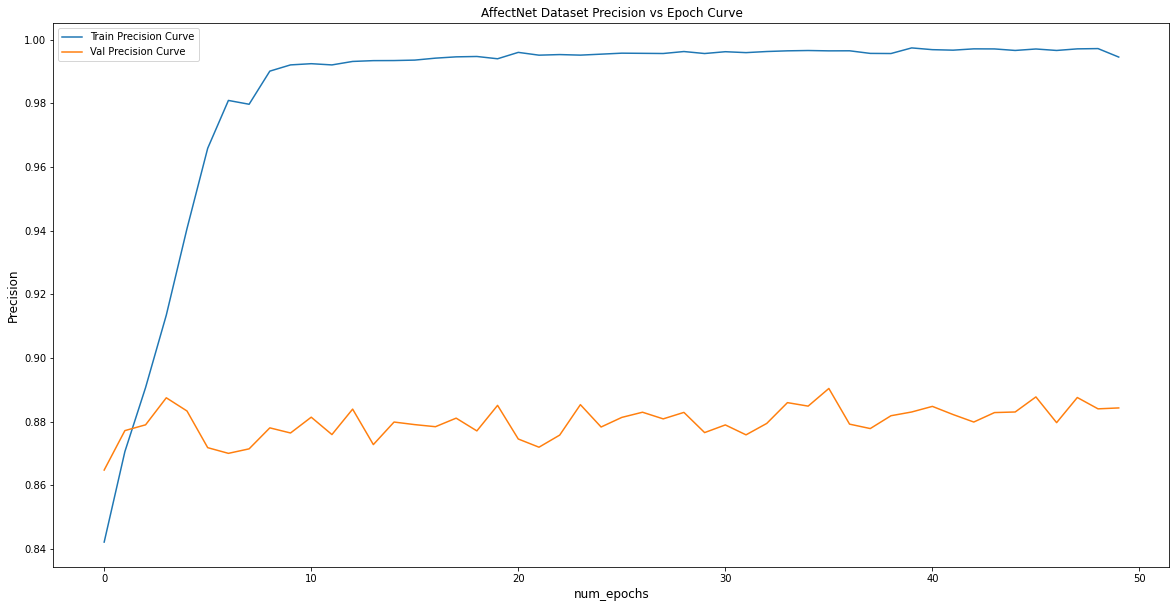

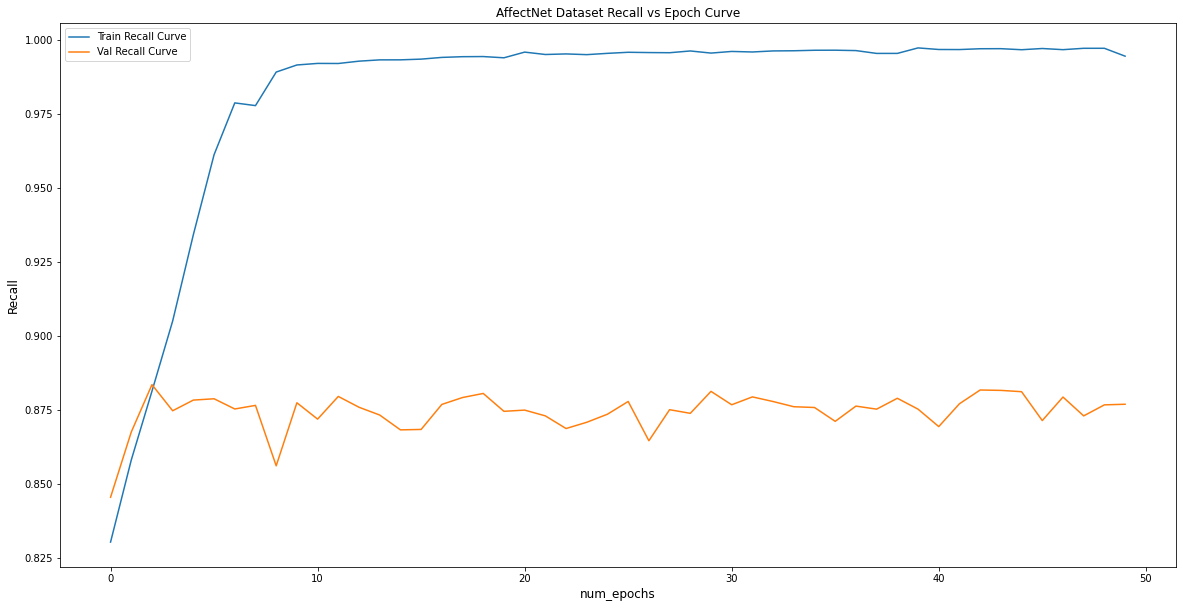

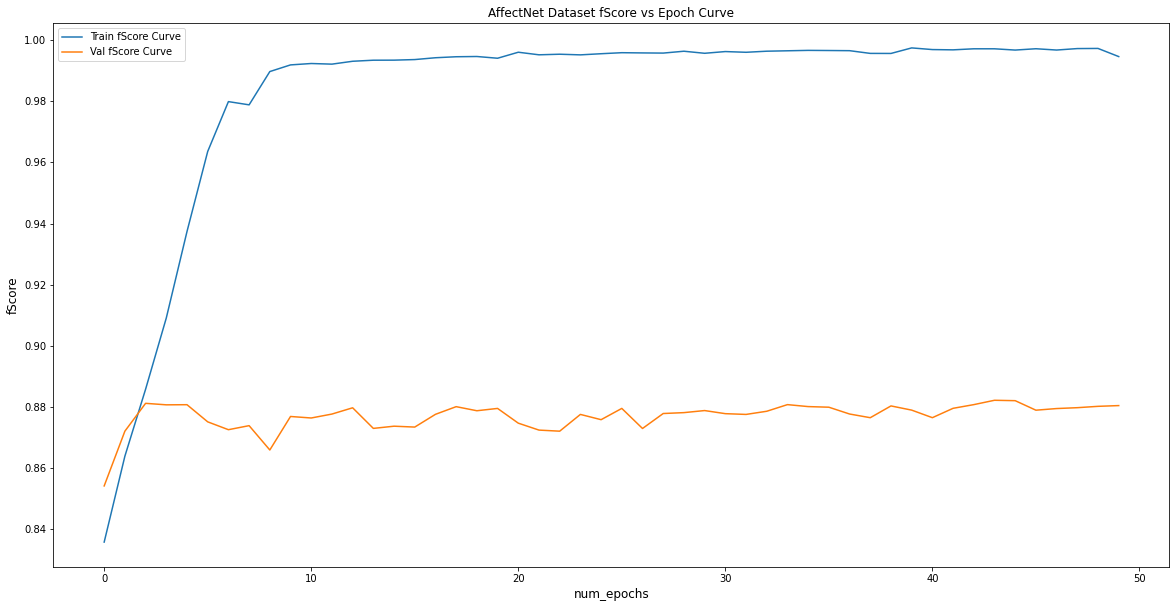

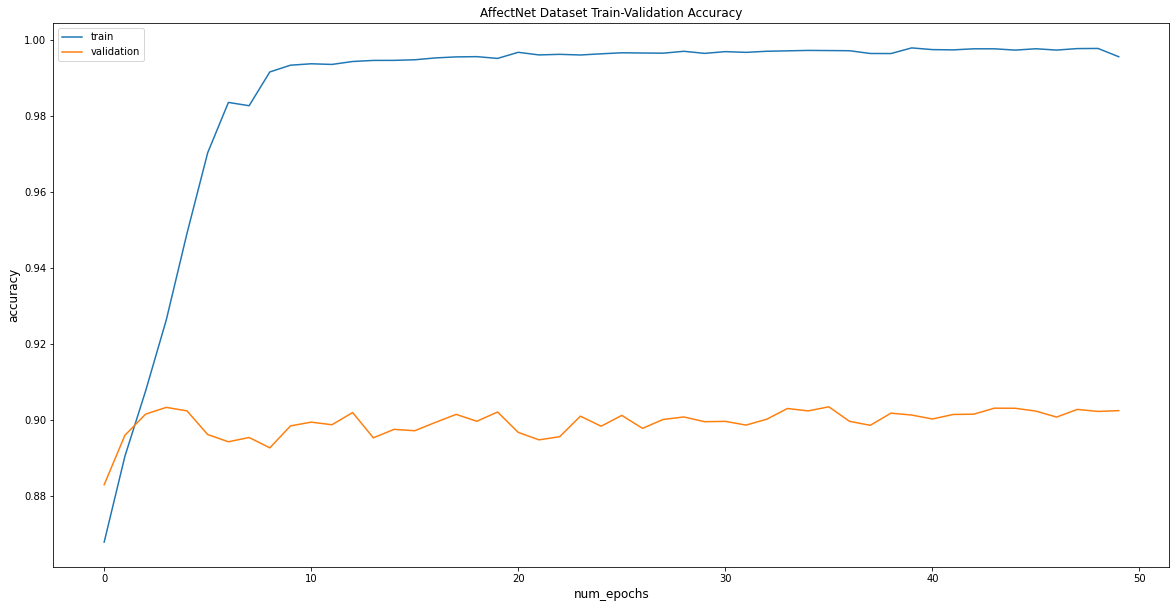

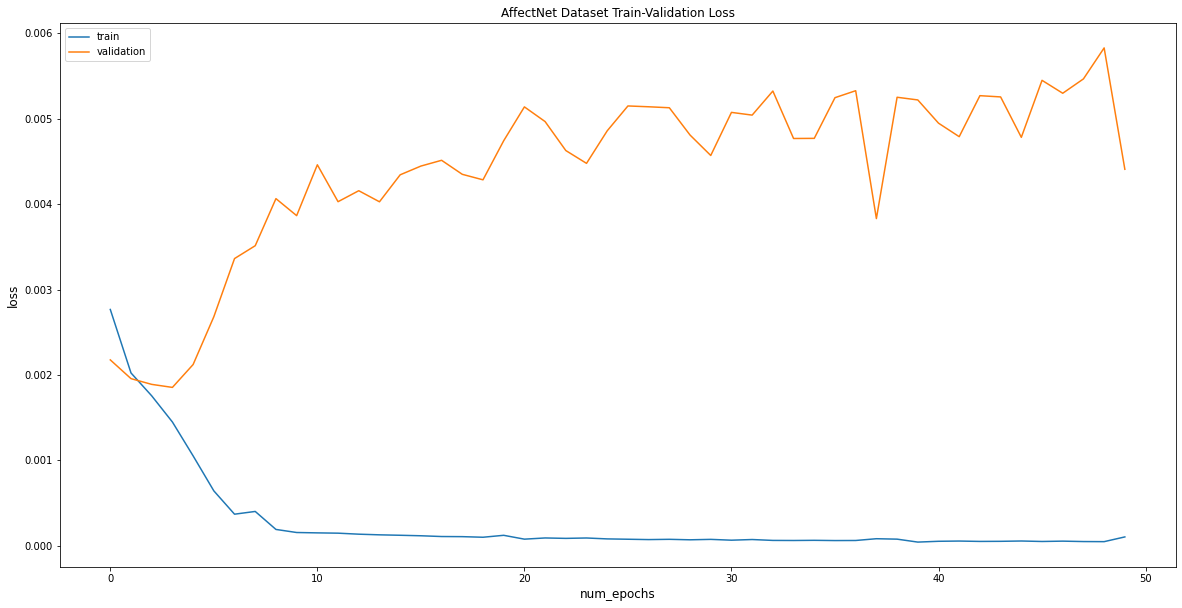

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn import svm, datasets

def generate_report(datatitle, epochLabel, label, pred_label, report):
  print("======================")
  print("Report Begin for: "+datatitle)
  print()

  if report['accuracy_score']:
    _score = accuracy_score(label, pred_label)
    print("Accuracy: {:.3f}% ".format(_score*100))
    print()

  if report['confusion_matrix']:
    print("Confusion Matrix:")
    conf_mat = confusion_matrix(label, pred_label)
    print(conf_mat)
    print()

  if report['classification_report']:
    print("Classification Report")
    cf_report = classification_report(label, pred_label)
    print(cf_report)
    print()

  if report['precision_recall_fscore']:
    print("Precision Recall fScore")
    p = precision_recall_fscore_support(label, pred_label, average='macro')
    print(p)
    print("Precision: "+str(p[0]))
    print("Recall: "+str(p[1]))
    print("f1 Score: "+str(p[2]))

    if(report['store']):
      if datatitle is "Train":
        all_train_precision.append(p[0])
        all_train_recall.append(p[1])
        all_train_fscore.append(p[2])
      elif datatitle is "Val":
        all_val_precision.append(p[0])
        all_val_recall.append(p[1])
        all_val_fscore.append(p[2])
    print()

  print("Report End for: "+datatitle)
  print("======================")


# def generate_precision_recall(datatitle, label, pred_label, y_score):
  # print("======================")
  # print("Report Begin for: "+datatitle)

  # Create a simple classifier
  # average_precision = average_precision_score(pred_label.reshape(-1, 1), y_score)
  # print('Average precision-recall score: {0:0.2f}'.format(average_precision))
  # precision, recall, thresholds = precision_recall_curve(pred_label.reshape(-1, 1), y_score)
  # disp = plot_precision_recall_curve(classifier, label.reshape(-1, 1), pred_label.reshape(-1, 1))
  # disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))


  # # Create a simple classifier
  # random_state = np.random.RandomState(0)
  # classifier = svm.LinearSVC(random_state=random_state)
  # classifier.fit(label, pred_label)
  # y_score = classifier.decision_function(label)
  # average_precision = average_precision_score(pred_label, y_score)
  # print('Average precision-recall score: {0:0.2f}'.format(average_precision))
  # precision, recall, thresholds = precision_recall_curve(pred_label, y_score)
  # disp = plot_precision_recall_curve(classifier, label, pred_label)
  # disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

  # print("Report End for: "+datatitle)
  # print("======================")
  # return precision, recall, thresholds


# 
top_train_label = torch.cat(affectnet_top_train_labels, dim=0).cpu().numpy()
pred_train_label = torch.cat(affectnet_top_train_pred_labels, dim=0).cpu().numpy()

report={'accuracy_score':True, 'confusion_matrix':True, 'classification_report':True, 'precision_recall_fscore':True, 'store':False}
generate_report("Best Train", str(bestEpoch), top_train_label, pred_train_label, report)


# print("===================================")

top_val_label = torch.cat(affectnet_top_val_labels, dim=0).cpu().numpy()
pred_val_label = torch.cat(affectnet_top_val_pred_labels, dim=0).cpu().numpy()

report={'accuracy_score':True, 'confusion_matrix':True, 'classification_report':True, 'precision_recall_fscore':True, 'store':False}
generate_report("Best Val", str(bestEpoch), top_val_label, pred_val_label, report)


# print("===================================")
all_train_precision = []
all_train_recall = []
all_train_fscore = []

all_val_precision = []
all_val_recall = []
all_val_fscore = []

report={'accuracy_score':True, 'confusion_matrix':True, 'classification_report':True, 'precision_recall_fscore':True, 'store':True}
for x in range(epochs):
  affectnet_a_train_label = torch.cat(affectnet_all_train_labels[x], dim=0).cpu().numpy()
  affectnet_a_train_pred_label = torch.cat(affectnet_all_train_pred_labels[x], dim=0).cpu().numpy()

  affectnet_a_val_label = torch.cat(affectnet_all_val_labels[x], dim=0).cpu().numpy()
  affectnet_a_val_pred_label = torch.cat(affectnet_all_val_pred_labels[x], dim=0).cpu().numpy()

  generate_report("Train", str(x+1), affectnet_a_train_label, affectnet_a_train_pred_label, report)
  generate_report("Val", str(x+1), affectnet_a_val_label, affectnet_a_val_pred_label, report)

  # all_precision.append(a_precision)
  # all_recall.append(a_recall)
  # all_fscore.append(a_fscore)


print(all_train_precision)
print(all_val_precision)
print(all_train_recall)
print(all_val_recall)
print(all_train_fscore)
print(all_val_fscore)


#plot AffectNet Dataset precision-epoch

fig = plt.figure(figsize=(20,10))
plt.title("AffectNet Dataset Precision vs Epoch Curve")
plt.plot(all_train_precision, label='Train Precision Curve')
plt.plot(all_val_precision, label='Val Precision Curve')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(loc='best')

precision_curve = 'curve_precision.png'
fig.savefig(precision_curve, dpi=100)
!cp '{precision_curve}' "/content/drive/MyDrive/Colab Notebooks/Data/{precision_curve}"


#plot AffectNet Dataset recall-epoch

fig = plt.figure(figsize=(20,10))
plt.title("AffectNet Dataset Recall vs Epoch Curve")
plt.plot(all_train_recall, label='Train Recall Curve')
plt.plot(all_val_recall, label='Val Recall Curve')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend(loc='best')

recall_curve = 'curve_recall.png'
fig.savefig(recall_curve, dpi=100)
!cp '{recall_curve}' "/content/drive/MyDrive/Colab Notebooks/Data/{recall_curve}"


#plot AffectNet Dataset fscore-epoch

fig = plt.figure(figsize=(20,10))
plt.title("AffectNet Dataset fScore vs Epoch Curve")
plt.plot(all_train_fscore, label='Train fScore Curve')
plt.plot(all_val_fscore, label='Val fScore Curve')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('fScore', fontsize=12)
plt.legend(loc='best')

fscore_curve = 'curve_fscore.png'
fig.savefig(fscore_curve, dpi=100)
!cp '{fscore_curve}' "/content/drive/MyDrive/Colab Notebooks/Data/{fscore_curve}"


#plot AffectNet Dataset Train-Validation Accuracy
# affectnet_all_trainacc
# affectnet_all_valacc

fig = plt.figure(figsize=(20,10))
plt.title("AffectNet Dataset Train-Validation Accuracy")
plt.plot(affectnet_all_trainacc, label='train')
plt.plot(affectnet_all_valacc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

acc_curve = 'curve_acc.png'
fig.savefig(acc_curve, dpi=100)
!cp '{acc_curve}' "/content/drive/MyDrive/Colab Notebooks/Data/{acc_curve}"


#plot AffectNet Train-Validation Loss
# affectnet_all_trainloss
# affectnet_all_valloss

fig = plt.figure(figsize=(20,10))
plt.title("AffectNet Dataset Train-Validation Loss")
plt.plot(affectnet_all_trainloss, label='train')
plt.plot(affectnet_all_valloss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

loss_curve = 'curve_loss.png'
fig.savefig(loss_curve, dpi=100)
!cp '{loss_curve}' "/content/drive/MyDrive/Colab Notebooks/Data/{loss_curve}"




Mounted at /content/drive
['positive', 'negative']


Saving depositphotos_115168262-stock-photo-people-expressing-different-emotions.jpg to depositphotos_115168262-stock-photo-people-expressing-different-emotions.jpg
Processing Image:  depositphotos_115168262-stock-photo-people-expressing-different-emotions.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Main Image


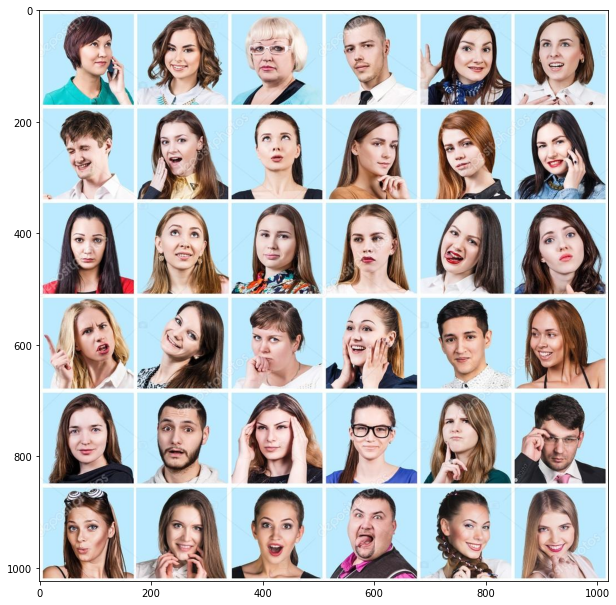

Predicted Image


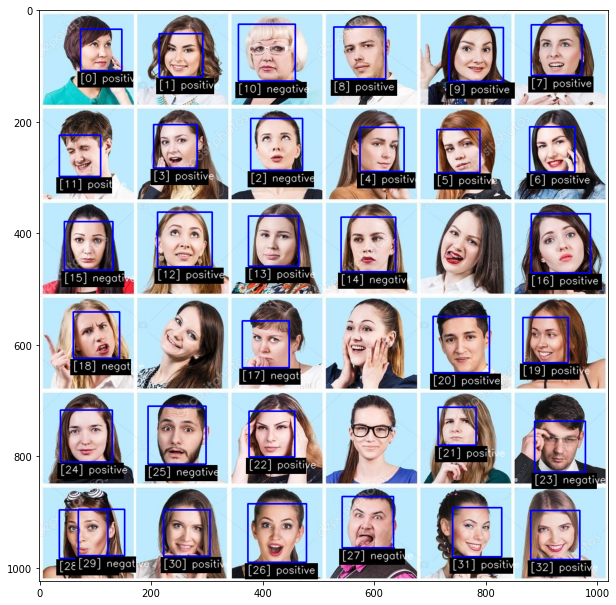

Predicted Faces in Image
11 3 33


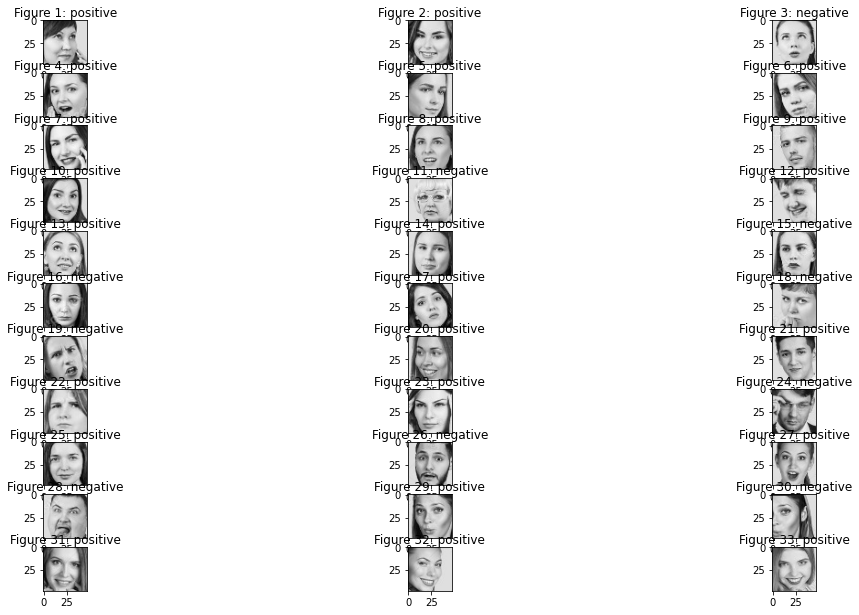

In [ ]:

# load affectnet saved model and visualize 

from __future__ import print_function
import argparse
import os
import cv2
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from matplotlib import pyplot as plt
from google.colab import drive
import time
from google.colab import files
import torch.nn as nn
import torchvision.models as models

def get_device(torch):
  return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive', force_remount=True)

device = get_device(torch)

affectnet_model_name = "affectnet_resnet18_model_facial_expression_datast.pt"

classes = ['positive', 'negative']

cam_multi_face = False # support web cam recorded video frame by frame analysis
cam_combined_face = False
photo = True # supports both single and multi face
use_photo_upload = True

testvideo = "test.mp4"
testphoto = "birthday-party.jpg"
tempphoto = "roi.jpg"


# checking model and cascade_model
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Data/"+affectnet_model_name):
  print(affectnet_model_name+" Model not found")
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Data/haarcascade_frontalface_default.xml"):
  print("cascade_model not found")

# creating virtual cascade_model folder
if not os.path.exists("cascade_model"):
  os.mkdir("cascade_model")

!cp "/content/drive/MyDrive/Colab Notebooks/Data/{affectnet_model_name}" "{affectnet_model_name}" 
!cp "/content/drive/MyDrive/Colab Notebooks/Data/haarcascade_frontalface_default.xml" "cascade_model/haarcascade_frontalface_default.xml"

# loading test photo is upload flag is off
if not use_photo_upload:
  !cp "/content/drive/MyDrive/Colab Notebooks/Data/{testphoto}" "{testphoto}"


# Load the cascade
face_cascade = cv2.CascadeClassifier('cascade_model/haarcascade_frontalface_default.xml')


transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])


net = models.resnet18()
#net.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) #default input layer
net.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=0, bias=False) #override input layer
# net.fc = nn.Linear(net.fc.in_features, 1000) #default output layer
net.fc = nn.Linear(net.fc.in_features, len(classes)) #override output layer


#print("Model:-", net)

net.load_state_dict(torch.load(affectnet_model_name))
net.to(device)
net.eval()


pred_y = []


#helper_function for real time testing
def load_img(path):
    img = Image.open(path)
    img = transformation(img).float()
    img = torch.autograd.Variable(img,requires_grad = True)
    img = img.unsqueeze(0)
    return img.to(device)

print(classes)
all_faces=[]
all_predictions=[]

if photo:
  if use_photo_upload:
    uploaded = files.upload()
    filename = next(iter(uploaded))
    print("Processing Image: ", filename)
    # filenames = uploaded.keys()
    # for file in filenames:
        # data = uploaded[file]
        # print(len(data), file)
    img = cv2.imread(filename)
    img_name = filename
  else:
    img = cv2.imread(testphoto)
    img_name = testphoto


  height, width, channels = img.shape

  # Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Detect the faces
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  # Draw the rectangle around each face
  roi_count = 0


  for (x, y, w, h) in faces:
    roi = img[y:y+h, x:x+w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi = cv2.resize(roi,(48,48))

    cv2.imwrite(tempphoto, roi) # save temporary img
    imgg = load_img(tempphoto) #load temp img

    out = net(imgg)
    pred = F.softmax(out)
    # print('face:'+str(roi_count), pred)
    # print('face:'+str(roi_count), pred.max().item())
    classs = torch.argmax(pred,1)
    wrong = torch.where(classs != 3,torch.tensor([1.]).cuda(),torch.tensor([0.]).cuda())
    classs = torch.argmax(pred,1)
    # print(classes)
    prediction = classes[classs.item()]

    font = cv2.FONT_HERSHEY_SIMPLEX
    new_x = x
    new_y = y+h+20
    new_y = new_y if new_y<height else y-20
    # print("y", new_y)
    # print("h", height)
    org = (new_x, new_y)
    fontScale = 0.6
    boxcolor = (255, 0, 0)
    textcolor = (255, 255, 255)
    boxthickness = 2
    textthickness = 1
    # print('face:'+str(roi_count), prediction)
    cv2.rectangle(img, (x, y), (x+w, y+h), boxcolor, boxthickness)
    cv2.rectangle(img, (new_x-5, new_y-18), (new_x+w+20, new_y+10), (0,0,0), -1)
    cv2.putText(img, "["+str(roi_count)+"] "+prediction, org, font, fontScale, textcolor, textthickness, cv2.LINE_AA)
    
    target_dir = "data"+"/predictions/"+prediction+"/"
    if not os.path.exists(target_dir):
      os.makedirs(target_dir);
    target_filename = target_dir +"pred_"+ str(len([name for name in os.listdir(target_dir) if os.path.isfile(os.path.join(target_dir, name))]))+".jpg"
    cv2.imwrite(target_filename, roi)
    all_faces.append(target_filename)
    all_predictions.append(prediction)

    roi_count = roi_count+1
  
  # print("face count: ", roi_count)

  #  cv2.imshow shows error
  # cv2.imshow('img', img)
  #Showing the image with matplotlib

  print ("Main Image")
  fig = plt.gcf()
  org_img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
  org_img_height, org_img_width, org_img_channels = org_img.shape
  # fig.set_size_inches(org_img_width/9.25, org_img_height/9.25, forward=True)
  fig.set_size_inches(18.5, 10.5, forward=True)
  plt.imshow(org_img)
  plt.show()

  print ("Predicted Image")
  fig = plt.gcf()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # fig.set_size_inches(width/9.25, height/9.25, forward=True)
  fig.set_size_inches(18.5, 10.5, forward=True)
  plt.imshow(img)
  plt.show()

  fig.savefig('pred_'+img_name, dpi=100)

  # save predicted image in google drive

  if photo:
    !cp 'pred_{img_name}' "/content/drive/MyDrive/Colab Notebooks/Data/pred_{img_name}"

  print ("Predicted Faces in Image")
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5, forward=True)
  # fig.tight_layout(pad=5.0)


  colsize = 3
  row = int(len(all_faces)/colsize)
  residue = len(all_faces)%colsize
  if residue>0:
      row = row + 1

  print(row, colsize, len(all_faces))
  # for i in range(1, (colsize*row)+1 ):
  for i, facepath in enumerate(all_faces):
    # if i > len(all_faces):
    #   break;
    # facepath = all_faces[i-1]
    # print(face)
    face = cv2.imread(facepath)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    subplot = fig.add_subplot(row, colsize, i+1)
    subplot.axes.set_title("Figure "+str(i+1)+": "+all_predictions[i], pad=2)
    plt.imshow(face)
  plt.show()
  
  fig.savefig('predface_'+img_name, dpi=100)
  # save predicted image in google drive
  if photo:
    !cp 'predface_{img_name}' "/content/drive/MyDrive/Colab Notebooks/Data/predface_{img_name}"

  # print(all_faces)
  # print("breaking at i: "+str(i))

else:
  print("Nothing specified")


**=========== END OF PROGRAM ===========**